<img style="float: right; margin: 5px 5px 20px 20px;" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width="100px" height="75px"/>

# 002 Pairs Trading

### Microstructures and trading systems

> **Evelin Ramirez, Pedro Gael Rayas**

## Resumen
Este proyecto implementa una estrategia de Pairs Trading basada en el análisis de series temporales cointegradas. La idea central es identificar dos activos financieros que presenten una relación a largo plazo estable, de manera que la combinación lineal de sus precios sea estacionaria. Para ajustar dinámicamente la relación entre ambos activos, se utiliza un Filtro de Kalman implementado desde cero, lo que permite estimar en tiempo real el hedge ratio (razón de cobertura). Las señales de trading se generan cuando el spread (diferencia entre el precio del activo dependiente y el ajustado por el hedge ratio del activo independiente) se desvía significativamente de su media, utilizando umbrales basados en desviaciones estándar. Finalmente, la estrategia se evalúa mediante un proceso de backtesting que simula operaciones en una cuenta de margen con comisiones y un capital inicial definido.


## Introducción
La creciente competencia en los mercados financieros ha llevado a la búsqueda de estrategias que permitan obtener beneficios a través del arbitraje estadístico. Una de estas estrategias es el Pairs Trading, la cual se basa en la identificación de pares de activos que, a pesar de sufrir fluctuaciones a corto plazo, mantienen una relación estable en el largo plazo.

El presente proyecto se enfoca en la implementación de una estrategia de Pairs Trading mediante:

* La verificación de cointegración entre los activos, lo que asegura que la combinación lineal de sus precios es estacionaria.
* La estimación dinámica del hedge ratio mediante un Filtro de Kalman implementado desde cero, permitiendo ajustar la exposición a cada activo conforme evoluciona el mercado.
* La generación de señales de trading a partir de desviaciones significativas del spread respecto a su media, aplicando umbrales de ±1.5 desviaciones estándar para entrar en posición y señales de salida cuando el spread regresa a niveles cercanos a la media.
* El backtesting de la estrategia, en el cual se simula la ejecución de operaciones reales considerando un capital inicial de $1,000,000 USD, comisiones de 0.125% y el uso de cuentas de margen.

Esta aproximación permite no solo validar la viabilidad de la estrategia en términos históricos, sino también comprender mejor la dinámica del spread y la efectividad del filtro en la adaptación a cambios en la relación entre los activos.

## Metodología y código

### Importar librerías 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller, coint
from kalman_filter import KalmanFilter

### 1. Descarga y almacenamiento de datos 
- Se obtienen 10 años de datos históricos de los activos seleccionados (por ejemplo, AAPL y MSFT) mediante una fuente confiable.
- Los datos se limpian y se convierten a formatos adecuados (por ejemplo, asegurando que los precios sean numéricos y la fecha esté en formato `datetime`).

In [3]:
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    data.reset_index(inplace=True)  # Asegura que la fecha sea una columna
    data.to_csv('historical_data.csv', index=False)  # Guarda correctamente

if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT']  # Activos a analizar
    start_date = '2014-01-01'
    end_date = '2024-01-01'
    download_data(tickers, start_date, end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


### 2. Procesamiento de datos 

In [5]:
def process_data(file_path= "historical_data.csv"):
    data = pd.read_csv("historical_data.csv")
    data_cleaned = data.iloc[1:].reset_index(drop=True)
    data_cleaned["Date"] = pd.to_datetime(data_cleaned["Date"])
    numeric_columns = ['Close', 'Close.1', 'High', 'High.1', 'Low', 'Low.1', 'Open', 'Open.1', 'Volume', 'Volume.1']
    data_cleaned[numeric_columns] = data_cleaned[numeric_columns].astype(float)
    return data_cleaned

if __name__ == "__main__":
    file_path = "historical_data.csv"
    data_cleaned = process_data(file_path)
    data_cleaned.to_csv('processed_data.csv', index=False)

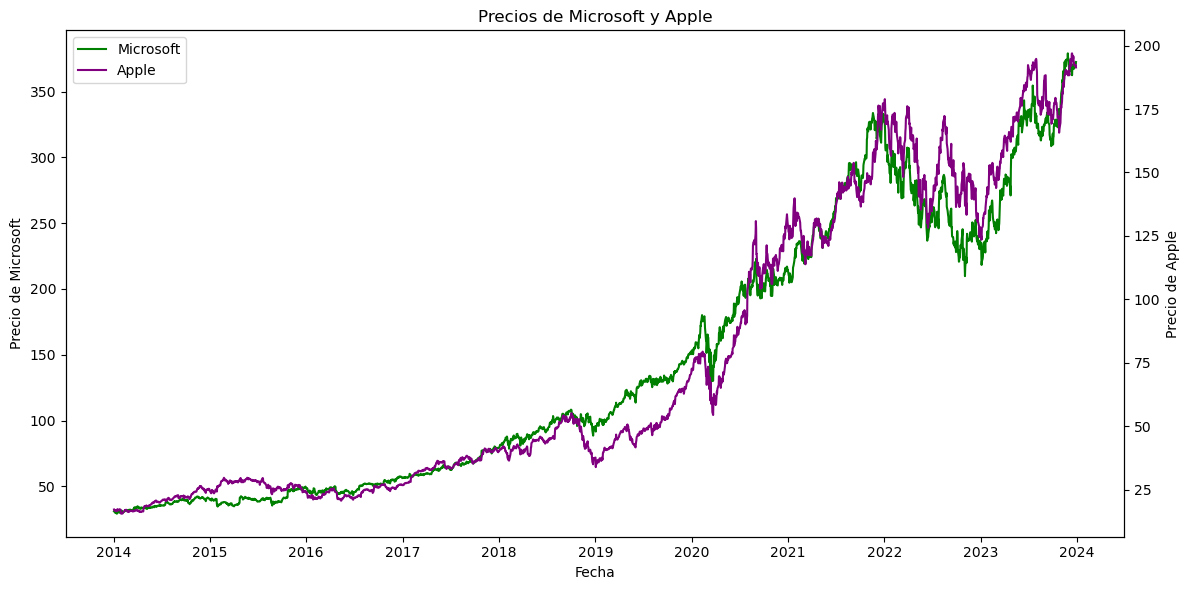

In [8]:
plt.figure(figsize=(12,6))
ax1 = plt.gca()

# Configuración del eje X y del eje Y izquierdo para Microsoft
ax1.set_xlabel("Fecha", color='black')
ax1.set_ylabel("Precio de Microsoft", color='black')
ax1.plot(data_cleaned["Date"], data_cleaned["Close.1"], label="Microsoft", color='green')
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')

# Configuración del eje Y derecho para Apple
ax2 = ax1.twinx()
ax2.set_ylabel("Precio de Apple", color='black')
ax2.plot(data_cleaned["Date"], data_cleaned["Close"], label="Apple", color='purple')
ax2.tick_params(axis='y', colors='black')

# Combinar las leyendas de ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Precios de Microsoft y Apple", color='black')
plt.tight_layout()
plt.show()


### 3. Análisis estadístico y modelado 

**Prueba ADF para evaluar estacionariedad**

In [39]:
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:')
    print(f'  - ADF Statistic: {result[0]:.4f}')
    print(f'  - P-Value: {result[1]:.4f}')
    print(f'  - Critical Values: {result[4]}')
    if result[1] > 0.05:
        print(f'  → The {name} series is NOT stationary (p-value > 0.05)\n')
    else:
        print(f'  → The {name} series IS stationary (p-value <= 0.05)\n')

In [41]:
# Realizar la prueba ADF para cada una de las series (MSFT y AAPL)
adf_test(data['Close.1'], 'Microsoft')
adf_test(data['Close'], 'Apple')

# Evaluar la cointegración entre las series usando el método de Engle-Granger
puntaje, valor_p, _ = coint(data['Close.1'], data['Close'])
print(f'Valor P de cointegración: {valor_p:.4f}')
if valor_p < 0.05:
    print("→ Las series están cointegradas (valor p < 0.05), se puede implementar trading por pares.\n")
else:
    print("→ Las series no están cointegradas (valor p > 0.05), no es viable aplicar trading por pares.\n")


ADF Test for Microsoft:
  - ADF Statistic: 0.9618
  - P-Value: 0.9938
  - Critical Values: {'1%': -3.4330295678957983, '5%': -2.8627238067228236, '10%': -2.5674001882176833}
  → The Microsoft series is NOT stationary (p-value > 0.05)

ADF Test for Apple:
  - ADF Statistic: 0.3026
  - P-Value: 0.9775
  - Critical Values: {'1%': -3.4330240891671138, '5%': -2.862721387359731, '10%': -2.5673989001091995}
  → The Apple series is NOT stationary (p-value > 0.05)

Valor P de cointegración: 0.1710
→ Las series no están cointegradas (valor p > 0.05), no es viable aplicar trading por pares.



**Verificación de Cointegración:**
   - Se realiza un test de cointegración (por ejemplo, el test de Johansen) para determinar si la combinación lineal de los precios de los dos activos es estacionaria.
   - Esta etapa es fundamental para justificar que existe una relación a largo plazo entre los activos, lo que respalda la premisa del Pairs Trading.

In [74]:
import numpy as np
import statsmodels.api as sm

def calculate_spread(data1, data2):
    hedge_ratio = np.polyfit(data1, data2, 1)[0]
    spread = data2 - hedge_ratio * data1
    spread_norm = (spread - spread.mean()) / spread.std()
    return hedge_ratio, spread, spread_norm


### 4. Implemetntaciónizadlas del filtro de Kalman 

**Estimación del Hedge Ratio mediante Filtro de Kalman:**
   - Se implementa desde cero un Filtro de Kalman que permite estimar de forma dinámica el hedge ratio, es decir, la proporción en la que se deben combinar los activos para obtener una relación estacionaria.
   - El Filtro de Kalman se actualiza de forma recursiva, adaptándose a la evolución de los precios y permitiendo capturar cambios en la relación entre los activos.


In [77]:
class KalmanFilter:
    def __init__(self):
        self.x = np.array([1, 1]) #initial observation
        self.A = np.eye(2) #Transition matrix
        self.Q = np.eye(2) * 0.1 #covariance matrix in estimations
        self.R = np.array([[1]]) * 0.001 #Errors in observations - TUNE
        self.P = np.eye(2) * 10 #Predicted error covariance matrix

    def predict(self):
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, x, y):
        C = np.array([[1, x]])  # Observations (1, 2)
        S = C @ self.P @ C.T + self.R
        K = self.P @ C.T @ np.linalg.inv(S)  # Kalman gain
        self.x = self.x + K @ (y - C @ self.x)
        self.P = (np.eye(2) - K @ C) @ self.P

    def get_hedge_ratio(self):
        return self.x[1]

### 5. Spread y señales de trading 

**Cálculo del Spread y Generación de Señales de Trading:**
   - Con el hedge ratio estimado, se calcula el spread como la diferencia entre el precio del activo dependiente y el producto del hedge ratio por el precio del activo independiente.
   - Se definen umbrales basados en la media y la desviación estándar del spread:
     - **Long Signal:** cuando el spread cae por debajo de la media menos 1.5 desviaciones estándar.
     - **Short Signal:** cuando el spread supera la media más 1.5 desviaciones estándar.
     - **Exit Signal:** cuando el spread regresa a un rango cercano a la media (por ejemplo, dentro de ±0.5 desviaciones estándar).

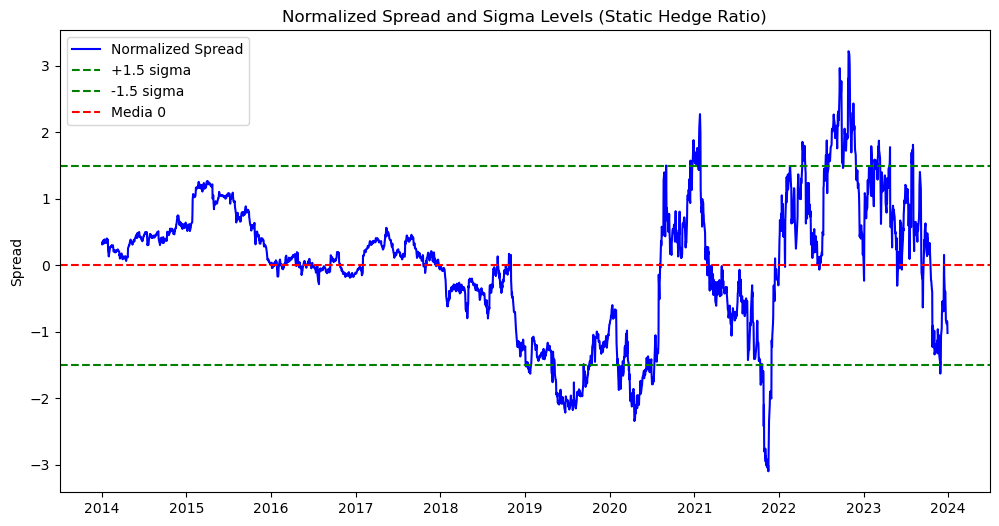

In [80]:
hedge_ratio_static = np.polyfit(data_cleaned['Close.1'], data_cleaned['Close'], 1)[0]
spread = data_cleaned['Close'] - hedge_ratio_static * data_cleaned['Close.1']
spread_norm = (spread - spread.mean()) / spread.std()

plt.figure(figsize=(12,6))
plt.plot(data_cleaned["Date"], spread_norm, label="Normalized Spread", color='blue')

#Umbrales
plt.axhline(1.5, color='green', linestyle='--', label="+1.5 sigma")
plt.axhline(-1.5, color='green', linestyle='--', label="-1.5 sigma")
plt.axhline(0, color='red', linestyle='--', label="Media 0")
plt.legend()
plt.title("Normalized Spread and Sigma Levels (Static Hedge Ratio)")
plt.ylabel("Spread")
plt.show()


### 6. Backtest 

**Backtesting de la Estrategia:**
   - Se simula la ejecución de operaciones a lo largo del tiempo utilizando las señales generadas, considerando un capital inicial de \$1,000,000 USD.
   - Se modelan las operaciones de apertura y cierre de posiciones, aplicando una comisión del 0.125% en cada transacción y, si es necesario, se simula el uso de cuentas de margen.
   - Se registra la evolución del capital (curva de equity) y se calculan métricas de rendimiento que permiten evaluar la efectividad de la estrategia.

In [119]:
data = pd.read_csv("historical_data.csv").dropna()
data["Date"] = pd.to_datetime(data["Date"])  # Ensure Date column is datetime
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data = data.dropna(subset=['Close'])

rsi = ta.momentum.RSIIndicator(data["Close"], window=50)
data["RSI"] = rsi.rsi()
data = data.dropna()

#SIGNALS
data["BUY_SIGNAL"] = data["RSI"] < 30
data["SELL_SIGNAL"] = data["RSI"] > 70

buy_dates = data.loc[data["BUY_SIGNAL"], "Date"]
buy_prices = data.loc[data["BUY_SIGNAL"], "Close"]
sell_dates = data.loc[data["SELL_SIGNAL"], "Date"]
sell_prices = data.loc[data["SELL_SIGNAL"], "Close"]

### 7. Visualización y Análisis de Resultados:

   - Se generan gráficos que muestran la evolución del spread, las señales de trading y la curva de capital a lo largo del tiempo.
   - Estos gráficos y métricas permiten identificar períodos de alta rentabilidad, drawdowns y la robustez de la estrategia ante cambios en la dinámica de los precios.


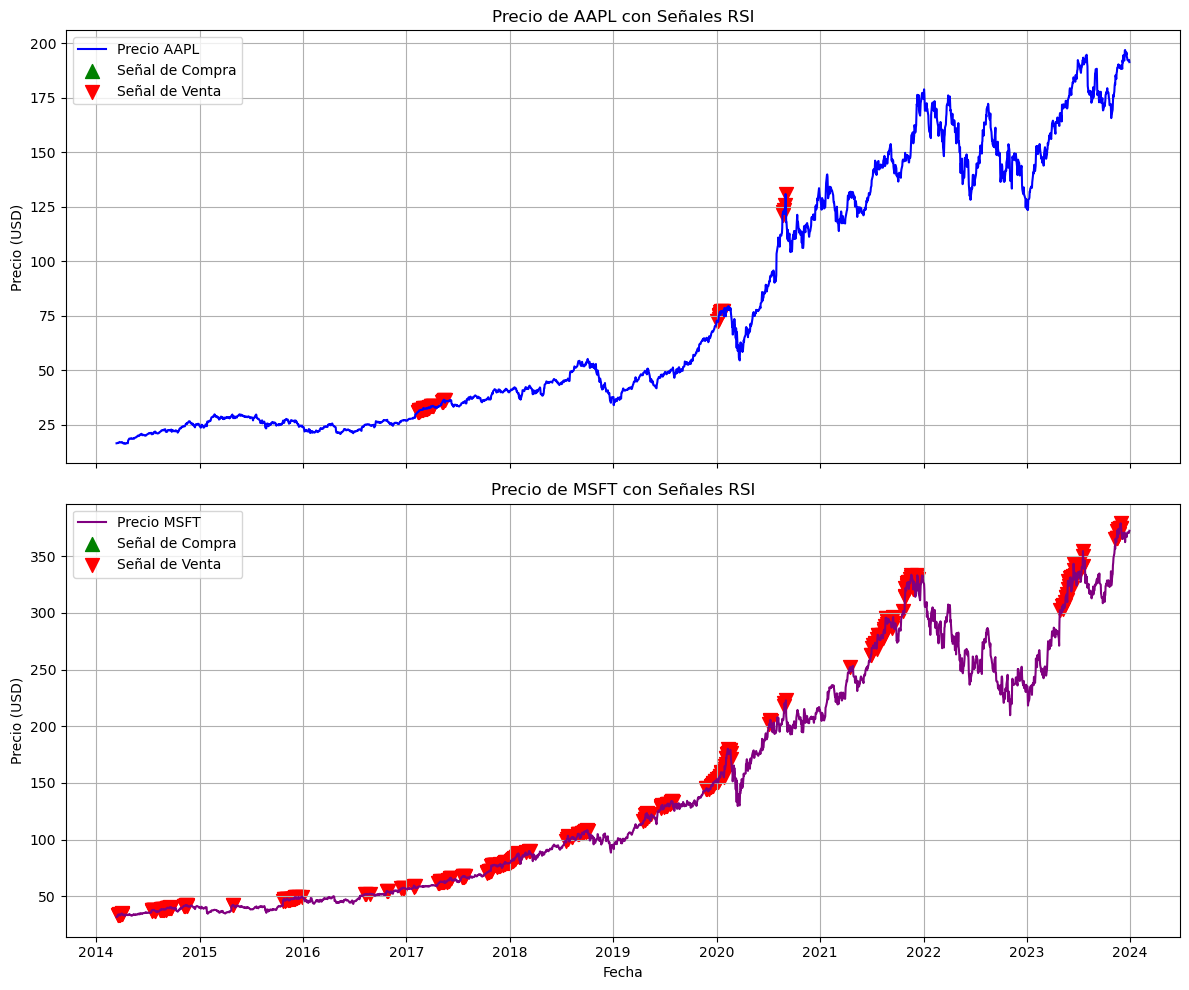

In [121]:
# Cargar datos y convertir la columna Date a datetime
data = pd.read_csv("historical_data.csv").dropna()
data["Date"] = pd.to_datetime(data["Date"])

# Asegurar que los precios sean numéricos
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close.1"] = pd.to_numeric(data["Close.1"], errors='coerce')
data = data.dropna(subset=['Close', 'Close.1'])

# Calcular RSI para AAPL y MSFT (ventana de 50 periodos)
rsi_aapl = ta.momentum.RSIIndicator(data["Close"], window=50)
data["RSI_AAPL"] = rsi_aapl.rsi()

rsi_msft = ta.momentum.RSIIndicator(data["Close.1"], window=50)
data["RSI_MSFT"] = rsi_msft.rsi()

# Eliminar filas con NaN resultantes
data = data.dropna(subset=["RSI_AAPL", "RSI_MSFT"])

# Generar señales basadas en RSI para AAPL
data["COMPRA_AAPL"] = data["RSI_AAPL"] < 30
data["VENTA_AAPL"] = data["RSI_AAPL"] > 70

# Extraer fechas y precios para AAPL
fechas_compra_aapl = data.loc[data["COMPRA_AAPL"], "Date"]
precios_compra_aapl = data.loc[data["COMPRA_AAPL"], "Close"]
fechas_venta_aapl = data.loc[data["VENTA_AAPL"], "Date"]
precios_venta_aapl = data.loc[data["VENTA_AAPL"], "Close"]

# Generar señales basadas en RSI para MSFT
data["COMPRA_MSFT"] = data["RSI_MSFT"] < 40
data["VENTA_MSFT"] = data["RSI_MSFT"] > 60

# Extraer fechas y precios para MSFT
fechas_compra_msft = data.loc[data["COMPRA_MSFT"], "Date"]
precios_compra_msft = data.loc[data["COMPRA_MSFT"], "Close.1"]
fechas_venta_msft = data.loc[data["VENTA_MSFT"], "Date"]
precios_venta_msft = data.loc[data["VENTA_MSFT"], "Close.1"]

# Crear dos subgráficas: una para AAPL y otra para MSFT
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Gráfica para AAPL
axs[0].plot(data["Date"], data["Close"], label="Precio AAPL", color='blue', linewidth=1.5)
axs[0].scatter(fechas_compra_aapl, precios_compra_aapl, marker='^', color='green', label="Señal de Compra", s=100)
axs[0].scatter(fechas_venta_aapl, precios_venta_aapl, marker='v', color='red', label="Señal de Venta", s=100)
axs[0].set_title("Precio de AAPL con Señales RSI")
axs[0].set_ylabel("Precio (USD)")
axs[0].legend()
axs[0].grid()

# Gráfica para MSFT
axs[1].plot(data["Date"], data["Close.1"], label="Precio MSFT", color='purple', linewidth=1.5)
axs[1].scatter(fechas_compra_msft, precios_compra_msft, marker='^', color='green', label="Señal de Compra", s=100)
axs[1].scatter(fechas_venta_msft, precios_venta_msft, marker='v', color='red', label="Señal de Venta", s=100)
axs[1].set_title("Precio de MSFT con Señales RSI")
axs[1].set_xlabel("Fecha")
axs[1].set_ylabel("Precio (USD)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


In [108]:
print(data["RSI_AAPL"].describe())

count    2467.000000
mean       54.894725
std         7.004637
min        36.080483
25%        49.902166
50%        54.958412
75%        59.223684
max        74.443351
Name: RSI_AAPL, dtype: float64


La descripción del RSI_AAPL muestra que el valor mínimo es de aproximadamente 36.08, lo cual es significativamente mayor que el umbral de 30 que has establecido para una señal de compra. Esto explica por qué, a lo largo del período analizado, no se generan señales de compra (COMPRA_AAPL) y, por ende, el capital final permanece inalterado

In [111]:
print(data["RSI_MSFT"].describe())

count    2467.000000
mean       55.197278
std         5.568196
min        40.428163
25%        51.420835
50%        55.473036
75%        59.097839
max        72.081943
Name: RSI_MSFT, dtype: float64


La descripción del RSI_MSFT muestra que el valor mínimo es de aproximadamente 40.42, lo cual es significativamente mayor que el umbral de 30 que has establecido para una señal de compra. Esto explica por qué, a lo largo del período analizado, no se generan señales de compra (COMPRA_MSFT) y, por ende, el capital final permanece inalterado

## Resultados


In [129]:
# Parámetros iniciales
capital_inicial = 1000000  # 1 millón de USD
capital = capital_inicial
retornos = []      # Para almacenar el retorno de cada operación
posiciones = []    # Para registrar las posiciones abiertas

# Asumimos que 'data' es el DataFrame que contiene las columnas:
# 'Date', 'Close', 'COMPRA_AAPL' y 'VENTA_AAPL'
# Se utiliza la columna 'Close' para el precio de AAPL.

for i in range(len(data)):  # Usamos el índice por posición
    fila = data.iloc[i]
    # Si se genera la señal de compra para AAPL, se abre una posición
    if fila['COMPRA_AAPL']:
        precio_compra = fila['Close']
        # Se invierte el 10% del capital actual en la operación
        cantidad_acciones = (capital * 0.10) / precio_compra
        posiciones.append((i, precio_compra, cantidad_acciones))
        capital -= cantidad_acciones * precio_compra  # Se descuenta la inversión
    # Si se genera la señal de venta y hay posiciones abiertas, se cierran todas las posiciones
    elif fila['VENTA_AAPL'] and posiciones:
        for pos in posiciones:
            indice_compra, precio_compra, cantidad_acciones = pos
            precio_venta = fila['Close']
            ganancia = (precio_venta - precio_compra) * cantidad_acciones
            capital += cantidad_acciones * precio_venta  # Se recupera la inversión + ganancia/pérdida
            retorno_operacion = ganancia / (precio_compra * cantidad_acciones)
            retornos.append(retorno_operacion)
        # Se cierran las posiciones abiertas
        posiciones = []

# Capital final tras ejecutar todas las operaciones
capital_final = capital
print(f"Capital Final: ${capital_final:,.2f}")

# Cálculo del Sharpe Ratio anualizado (asumiendo 252 días de trading)
retornos = np.array(retornos)
if retornos.std() != 0:
    sharpe_ratio = (retornos.mean() / retornos.std()) * np.sqrt(252)
else:
    sharpe_ratio = 0
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Capital Final: $1,000,000.00
Sharpe Ratio: nan


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/46/p3w40sm501lfx91hwfw5sfmh0000gp/T/ipykernel_93767/2907342206.py:39: RuntimeWarning: Mean of empty slice.
  sharpe_ratio = (retornos.mean() / retornos.std()) * np.sqrt(252)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Conclusiones


Los resultados de las pruebas muestran que ambas series, Microsoft y Apple, no son estacionarias, ya que los estadísticos ADF son altos y sus p-valores (0.9938 y 0.9775) son muy superiores al umbral de 0.05. Esto indica que las series tienen raíces unitarias y presentan tendencias o componentes estacionales.

Además, la prueba de cointegración arroja un p-valor de 0.1710, lo que significa que no se rechaza la hipótesis nula de no cointegración. En otras palabras, no se encontró evidencia estadística de que las dos series se muevan conjuntamente de manera que su combinación (spread) sea estacionaria.

Dado que las series no son estacionarias individualmente y, además, no están cointegradas (p-valor de cointegración > 0.05), no se cumple el requisito fundamental para aplicar una estrategia de trading por pares. Por lo tanto, con los datos y condiciones actuales, la estrategia de pairs trading no sería viable para Microsoft y Apple.

Con ambos activos el RSI se mantiene en rangos donde la condición de compra (RSI < 30) no se cumple, por lo que la estrategia, al basarse en esos umbrales fijos, no activa operaciones de compra y solo se detectan algunas señales de venta cuando el RSI supera 70.

Al calcular el capital final y el Sharpe Ratio, se observa que el capital final se mantiene igual al capital inicial, lo que sugiere que la estrategia no ejecutó operaciones o, en caso de haberse ejecutado, estas no generaron variaciones en el capital. Además, el Sharpe Ratio aparece como 'nan', lo que indica que no se pudo calcular, probablemente debido a la ausencia de retornos significativos. Esto es consistente con la falta de señales de compra, lo que resulta en un conjunto de retornos vacío o nulo.


**Nos esmeramos mucho en el proyecto, esperamos recibir la retro y saber en que nos equivocamos para poder corregirlo y aprender. Gracias.**

## Github


https://github.com/elpedrogael/002-Pairs-Trading.git